In [1]:
!pip install torch torchvision numpy pandas pillow matplotlib seaborn scikit-learn tqdm gradio -q

print("All packages installed successfully!")

All packages installed successfully!


In [2]:
import os
import urllib.request
import tarfile
from pathlib import Path
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    """Progress bar for downloads"""
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_dataset(url, output_path):
    """Download file with progress bar"""
    with DownloadProgressBar(unit='B', unit_scale=True, miniters=1, desc='Downloading') as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def extract_dataset(tar_path, extract_path):
    """Extract tar.gz file"""
    print("Extracting dataset...")
    with tarfile.open(tar_path, 'r:gz') as tar:
        tar.extractall(path=extract_path)
    print("Extraction complete")

dataset_url = 'https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz'
dataset_path = Path('./fgvc-aircraft-2013b')
tar_file = Path('./fgvc-aircraft-2013b.tar.gz')

if not dataset_path.exists():
    print("Dataset not found. Starting automatic download...")
    print(f"URL: {dataset_url}")
    print(f"Size: ~2.5GB\n")

    try:
        if not tar_file.exists():
            print("Step 1/2: Downloading dataset...")
            download_dataset(dataset_url, tar_file)
            print(f"\nDownload complete: {tar_file}\n")
        else:
            print(f"Found existing download: {tar_file}\n")

        print("Step 2/2: Extracting dataset...")
        extract_dataset(tar_file, Path('.'))

        if dataset_path.exists():
            image_count = len(list((dataset_path / 'data' / 'images').glob('*.jpg')))
            print(f"\n Dataset ready!")
            print(f"  Location: {dataset_path}")
            print(f"  Images: {image_count}\n")

        else:
            print("Error: Dataset extraction failed")

    except Exception as e:
        print(f"\nError downloading dataset: {e}")
        print("\nManual download instructions:")
        print("1. Visit: https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz")
        print("2. Save file to current directory")
        print("3. Run: tar -xzf fgvc-aircraft-2013b.tar.gz")
else:
    image_count = len(list((dataset_path / 'data' / 'images').glob('*.jpg')))
    print(f"Dataset already available")
    print(f"Location: {dataset_path}")
    print(f"Images: {image_count}")

Dataset not found. Starting automatic download...
URL: https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz
Size: ~2.5GB

Step 1/2: Downloading dataset...


Downloading: 2.75GB [02:21, 19.5MB/s]                            
/tmp/ipython-input-3577361181.py:23: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_path)



Download complete: fgvc-aircraft-2013b.tar.gz

Step 2/2: Extracting dataset...
Extracting dataset...
Extraction complete

 Dataset ready!
  Location: fgvc-aircraft-2013b
  Images: 10000



In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import os
import json
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu126
CUDA available: True
CUDA device: Tesla T4


In [4]:
class AircraftDataset(Dataset):
    """Dataset class for FGVC-Aircraft dataset"""

    def __init__(self, root_dir, split='train', variant_level='variant',
                 transform=None, label_to_idx=None, idx_to_label=None):
        self.root_dir = Path(root_dir)
        self.data_dir = self.root_dir / 'data'
        self.images_dir = self.data_dir / 'images'
        self.split = split
        self.variant_level = variant_level
        self.transform = transform

        self.image_paths, self.labels = self._load_annotations()

        if label_to_idx is not None:
            self.label_to_idx = label_to_idx
            self.idx_to_label = idx_to_label
            self.unique_labels = list(idx_to_label.values())
        else:
            self.unique_labels = sorted(list(set(self.labels)))
            self.label_to_idx = {label: idx for idx, label in enumerate(self.unique_labels)}
            self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}

    def _load_annotations(self) -> Tuple[List[str], List[str]]:
        """Load image paths and labels from annotation files"""
        annotation_file = self.data_dir / f'images_{self.variant_level}_{self.split}.txt'

        image_paths = []
        labels = []

        with open(annotation_file, 'r') as f:
            for line in f:
                parts = line.strip().split(' ', 1)
                if len(parts) == 2:
                    img_name, label = parts
                    image_paths.append(self.images_dir / f'{img_name}.jpg')
                    labels.append(label)

        return image_paths, labels

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert('RGB')

        w, h = image.size
        image = image.crop((0, 0, w, h - 20))

        if self.transform:
            image = self.transform(image)

        return image, self.label_to_idx[label]

    def get_class_weights(self) -> torch.Tensor:
        """Calculate class weights for handling imbalanced dataset"""
        label_counts = {}
        for label in self.labels:
            label_idx = self.label_to_idx[label]
            label_counts[label_idx] = label_counts.get(label_idx, 0) + 1

        total_samples = len(self.labels)
        weights = []
        for i in range(len(self.unique_labels)):
            weight = total_samples / (len(self.unique_labels) * label_counts.get(i, 1))
            weights.append(weight)

        return torch.FloatTensor(weights)

print("AircraftDataset class defined")

AircraftDataset class defined


In [5]:
class AircraftClassifier(nn.Module):
    """Aircraft classification model based on ResNet50"""

    def __init__(self, num_classes: int, pretrained: bool = True):
        super(AircraftClassifier, self).__init__()

        self.backbone = models.resnet50(pretrained=pretrained)

        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

print("AircraftClassifier model defined")

AircraftClassifier model defined


In [6]:
class AircraftClassifierTrainer:
    """Training and evaluation pipeline for aircraft classifier"""

    def __init__(self, data_root: str, variant_level: str = 'variant',
                 batch_size: int = 32, num_workers: int = 4,
                 device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):

        self.data_root = data_root
        self.variant_level = variant_level
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.device = device

        # Image preprocessing
        self.train_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

        self.val_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

        # Load datasets
        self.train_dataset = AircraftDataset(
            data_root, 'train', variant_level, self.train_transform
        )
        self.val_dataset = AircraftDataset(
            data_root, 'val', variant_level, self.val_transform,
            label_to_idx=self.train_dataset.label_to_idx,
            idx_to_label=self.train_dataset.idx_to_label
        )

        # Create dataloaders
        self.train_loader = DataLoader(
            self.train_dataset, batch_size=batch_size, shuffle=True,
            num_workers=num_workers, pin_memory=True
        )
        self.val_loader = DataLoader(
            self.val_dataset, batch_size=batch_size, shuffle=False,
            num_workers=num_workers, pin_memory=True
        )

        # Initialize model
        num_classes = len(self.train_dataset.unique_labels)
        self.model = AircraftClassifier(num_classes).to(device)

        # Loss function with class weights
        class_weights = self.train_dataset.get_class_weights().to(device)
        self.criterion = nn.CrossEntropyLoss(weight=class_weights)

        # Optimizer and scheduler
        self.optimizer = optim.AdamW(self.model.parameters(), lr=1e-4, weight_decay=1e-4)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=3
        )

        # Training history
        self.history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': []
        }

    def train_epoch(self) -> Tuple[float, float]:
        """Train for one epoch"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(self.train_loader, desc='Training')
        for images, labels in pbar:
            images, labels = images.to(self.device), labels.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({'loss': loss.item(), 'acc': 100. * correct / total})

        epoch_loss = running_loss / len(self.train_loader.dataset)
        epoch_acc = 100. * correct / total
        return epoch_loss, epoch_acc

    def validate(self) -> Tuple[float, float]:
        """Validate model"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in tqdm(self.val_loader, desc='Validation'):
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(self.val_loader.dataset)
        epoch_acc = 100. * correct / total
        return epoch_loss, epoch_acc

    def train(self, num_epochs: int = 50, save_dir: str = 'checkpoints'):
        """Complete training loop"""
        save_path = Path(save_dir)
        save_path.mkdir(exist_ok=True)

        best_val_acc = 0.0

        print(f"\nTraining Aircraft Classifier ({self.variant_level} level)")
        print(f"Classes: {len(self.train_dataset.unique_labels)}")
        print(f"Train: {len(self.train_dataset)} | Val: {len(self.val_dataset)}")
        print(f"Device: {self.device}\n")

        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}")

            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc = self.validate()

            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)

            print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%\n")

            self.scheduler.step(val_loss)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_acc': val_acc,
                    'label_to_idx': self.train_dataset.label_to_idx,
                    'idx_to_label': self.train_dataset.idx_to_label,
                    'variant_level': self.variant_level
                }
                torch.save(checkpoint, save_path / f'best_model_{self.variant_level}.pth')
                print(f"Saved best model (Val Acc: {val_acc:.2f}%)\n")

        with open(save_path / f'history_{self.variant_level}.json', 'w') as f:
            json.dump(self.history, f, indent=2)

        print(f"Training complete! Best Val Acc: {best_val_acc:.2f}%")
        return self.history

    def plot_training_history(self):
        """Plot training history"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        ax1.plot(self.history['train_loss'], label='Train Loss')
        ax1.plot(self.history['val_loss'], label='Val Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.legend()
        ax1.grid(True)

        ax2.plot(self.history['train_acc'], label='Train Accuracy')
        ax2.plot(self.history['val_acc'], label='Val Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.set_title('Training and Validation Accuracy')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

print("AircraftClassifierTrainer class defined")

AircraftClassifierTrainer class defined


In [7]:
class AircraftInferenceEngine:
    """Production inference engine for aircraft classification"""

    def __init__(self, checkpoint_path: str, device: str = 'cpu'):
        self.device = device

        # Load checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=device)

        # Extract metadata
        self.label_to_idx = checkpoint['label_to_idx']
        # Ensure idx_to_label keys are integers if they were saved as such
        self.idx_to_label = {int(k): v for k, v in checkpoint['idx_to_label'].items()}
        self.variant_level = checkpoint.get('variant_level', 'variant')
        self.num_classes = len(self.idx_to_label)

        # Initialize model
        self.model = self._build_model(self.num_classes)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()

        # Preprocessing pipeline
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

        print(f"Inference engine initialized")
        print(f"Level: {self.variant_level} | Classes: {self.num_classes} | Device: {self.device}")

    def _build_model(self, num_classes: int) -> nn.Module:
        # Instantiate the same AircraftClassifier model structure as used in training
        model = AircraftClassifier(num_classes=num_classes, pretrained=False)
        return model.to(self.device)

    def preprocess_image(self, image_input):
        if isinstance(image_input, (str, Path)):
            image = Image.open(image_input).convert('RGB')
        elif isinstance(image_input, np.ndarray):
            image = Image.fromarray(image_input).convert('RGB')
        elif isinstance(image_input, Image.Image):
            image = image.convert('RGB')
        else:
            raise ValueError(f"Unsupported image type: {type(image_input)}")

        return self.transform(image).unsqueeze(0)

    def predict(self, image_input, top_k: int = 5) -> Dict:
        """Classify aircraft in image"""
        start_time = time.time()

        image_tensor = self.preprocess_image(image_input).to(self.device)

        with torch.no_grad():
            outputs = self.model(image_tensor)
            probabilities = torch.softmax(outputs, dim=1)

        top_probs, top_indices = probabilities.topk(top_k, dim=1)
        top_probs = top_probs.cpu().numpy()[0]
        top_indices = top_indices.cpu().numpy()[0]

        predictions = []
        for i, (idx, prob) in enumerate(zip(top_indices, top_probs)):
            aircraft_type = self.idx_to_label[idx] # Changed from str(idx) to idx
            predictions.append({
                'rank': i + 1,
                'aircraft_type': aircraft_type,
                'confidence': float(prob),
                'confidence_percent': f"{prob * 100:.2f}%"
            })

        inference_time = time.time() - start_time

        return {
            'primary_prediction': predictions[0]['aircraft_type'],
            'confidence': predictions[0]['confidence'],
            'top_predictions': predictions,
            'classification_level': self.variant_level,
            'inference_time_ms': f"{inference_time * 1000:.2f}",
            'timestamp': time.strftime('%Y-%m-%d %H:%M:%S')
        }

    def batch_predict(self, image_paths: List[str], top_k: int = 3) -> List[Dict]:
        results = []
        for img_path in image_paths:
            try:
                result = self.predict(img_path, top_k=top_k)
                result['image_path'] = img_path
                results.append(result)
            except Exception as e:
                results.append({'image_path': img_path, 'error': str(e)})
        return results

print("AircraftInferenceEngine class defined")

AircraftInferenceEngine class defined


In [8]:
class OperationalAssistant:
    """Helper class for operational use cases"""

    def __init__(self, inference_engine):
        self.engine = inference_engine

    def identify_for_stand_planning(self, image_input) -> Dict:
        """Identify aircraft for stand planning"""
        prediction = self.engine.predict(image_input, top_k=3)

        aircraft_type = prediction['primary_prediction']
        confidence = prediction['confidence']

        return {
            'aircraft_identified': aircraft_type,
            'confidence': f"{confidence * 100:.1f}%",
            'stand_planning_assumptions': {
                'aircraft_family': aircraft_type,
                'classification_certainty': 'high' if confidence > 0.8 else 'medium' if confidence > 0.6 else 'low',
                'alternative_possibilities': [p['aircraft_type'] for p in prediction['top_predictions'][1:3]],
                'recommendation': self._get_recommendation(confidence)
            },
            'full_prediction': prediction
        }

    def _get_recommendation(self, confidence: float) -> str:
        if confidence > 0.85:
            return "High confidence - proceed with standard stand allocation"
        elif confidence > 0.70:
            return "Medium confidence - consider flexible stand allocation"
        else:
            return "Low confidence - recommend visual verification"

    def training_mode_analysis(self, image_input) -> Dict:
        """Detailed analysis for training purposes"""
        prediction = self.engine.predict(image_input, top_k=10)

        aircraft_type = prediction['primary_prediction']
        confidence = prediction['confidence']

        learning_points = []
        if confidence > 0.9:
            learning_points.append("Clear example of the aircraft type")
        elif confidence > 0.7:
            learning_points.append("Good classification with some visual ambiguity")
        else:
            learning_points.append("Challenging classification - study distinguishing features")

        if len(prediction['top_predictions']) > 1:
            alt = prediction['top_predictions'][1]
            learning_points.append(f"Most similar: {alt['aircraft_type']} ({alt['confidence_percent']})")

        confusion_risks = []
        if len(prediction['top_predictions']) > 1:
            secondary = prediction['top_predictions'][1]
            if secondary['confidence'] > 0.2:
                confusion_risks.append(f"May confuse with {secondary['aircraft_type']} ({secondary['confidence_percent']})")

        if not confusion_risks:
            confusion_risks.append("No significant confusion risks identified")

        return {
            'identified_aircraft': aircraft_type,
            'confidence_score': confidence,
            'classification_level': prediction['classification_level'],
            'top_10_possibilities': prediction['top_predictions'],
            'learning_points': learning_points,
            'visual_identification_features': [
                "Wing configuration",
                "Engine placement",
                "Fuselage shape",
                f"Specific to {aircraft_type}"
            ],
            'confusion_risks': confusion_risks
        }

print("OperationalAssistant class defined")

OperationalAssistant class defined


In [9]:
print("Core Classes Defined (with existence check):")
print("--------------------------------------")

core_classes = [
    "DownloadProgressBar",
    "AircraftDataset",
    "AircraftClassifier",
    "AircraftClassifierTrainer",
    "AircraftInferenceEngine",
    "OperationalAssistant"
]

for class_name in core_classes:
    if class_name in globals() and isinstance(globals()[class_name], type):
        print(f"- {class_name} (Defined)")
    else:
        print(f"- {class_name} (Not Defined or Not a Class)")

Core Classes Defined (with existence check):
--------------------------------------
- DownloadProgressBar (Defined)
- AircraftDataset (Defined)
- AircraftClassifier (Defined)
- AircraftClassifierTrainer (Defined)
- AircraftInferenceEngine (Defined)
- OperationalAssistant (Defined)


Dataset found!

Total images: 10000


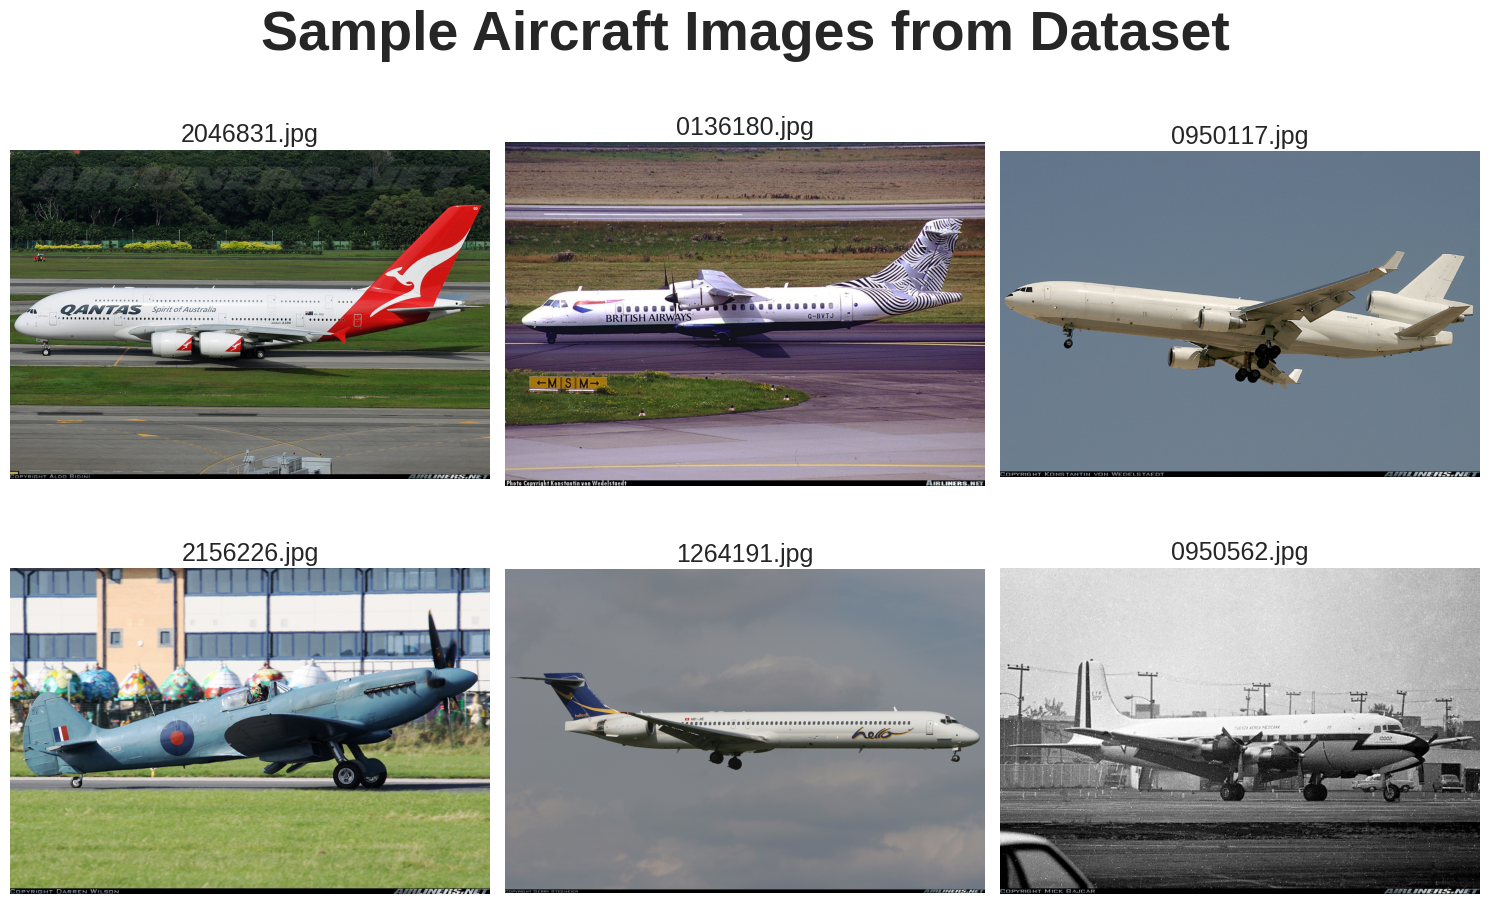

In [10]:
# Explore dataset structure
data_root = './fgvc-aircraft-2013b'

# Check if dataset exists
if os.path.exists(data_root):
    print("Dataset found!\n")

    # Count images
    images_dir = Path(data_root) / 'data' / 'images'
    image_count = len(list(images_dir.glob('*.jpg')))
    print(f"Total images: {image_count}")

    # Show sample images
    sample_images = list(images_dir.glob('*.jpg'))[:6]

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for idx, img_path in enumerate(sample_images):
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(img_path.name, fontsize=18)

    plt.suptitle('Sample Aircraft Images from Dataset', fontsize= 40, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("Dataset not found. Please download and extract it first.")
    print("URL: https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz")

In [11]:
# Configuration
DATA_ROOT = './fgvc-aircraft-2013b'
VARIANT_LEVEL = 'family'  # Change to 'variant' or 'manufacturer' as needed
BATCH_SIZE = 32
NUM_EPOCHS = 5  # Start with 5 for testing, use 50+ for production
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Configuration:")
print(f"  Level: {VARIANT_LEVEL}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Device: {DEVICE}")

Configuration:
  Level: family
  Batch size: 32
  Epochs: 5
  Device: cuda


In [12]:
# Initialize trainer
trainer = AircraftClassifierTrainer(
    data_root=DATA_ROOT,
    variant_level=VARIANT_LEVEL,
    batch_size=BATCH_SIZE,
    num_workers=2,  # Adjust based on your CPU
    device=DEVICE
)

print(f"\n  Trainer initialized")
print(f"  Aircraft classes: {len(trainer.train_dataset.unique_labels)}")
print(f"  Training samples: {len(trainer.train_dataset)}")
print(f"  Validation samples: {len(trainer.val_dataset)}")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 62.4MB/s]



  Trainer initialized
  Aircraft classes: 70
  Training samples: 3334
  Validation samples: 3333



Training Aircraft Classifier (family level)
Classes: 70
Train: 3334 | Val: 3333
Device: cuda

Epoch 1/5


Validation: 100%|██████████| 105/105 [00:42<00:00,  2.48it/s]


Train Loss: 4.1167, Acc: 4.29%
Val Loss: 3.6396, Acc: 13.14%

Saved best model (Val Acc: 13.14%)

Epoch 2/5


Validation: 100%|██████████| 105/105 [00:40<00:00,  2.61it/s]


Train Loss: 3.1172, Acc: 18.39%
Val Loss: 2.4615, Acc: 36.39%

Saved best model (Val Acc: 36.39%)

Epoch 3/5


Validation: 100%|██████████| 105/105 [00:40<00:00,  2.62it/s]


Train Loss: 2.1712, Acc: 35.30%
Val Loss: 1.9025, Acc: 42.24%

Saved best model (Val Acc: 42.24%)

Epoch 4/5


Validation: 100%|██████████| 105/105 [00:40<00:00,  2.58it/s]


Train Loss: 1.6203, Acc: 46.28%
Val Loss: 1.5334, Acc: 52.69%

Saved best model (Val Acc: 52.69%)

Epoch 5/5


Validation: 100%|██████████| 105/105 [00:40<00:00,  2.57it/s]


Train Loss: 1.2385, Acc: 57.17%
Val Loss: 1.2301, Acc: 61.84%

Saved best model (Val Acc: 61.84%)

Training complete! Best Val Acc: 61.84%


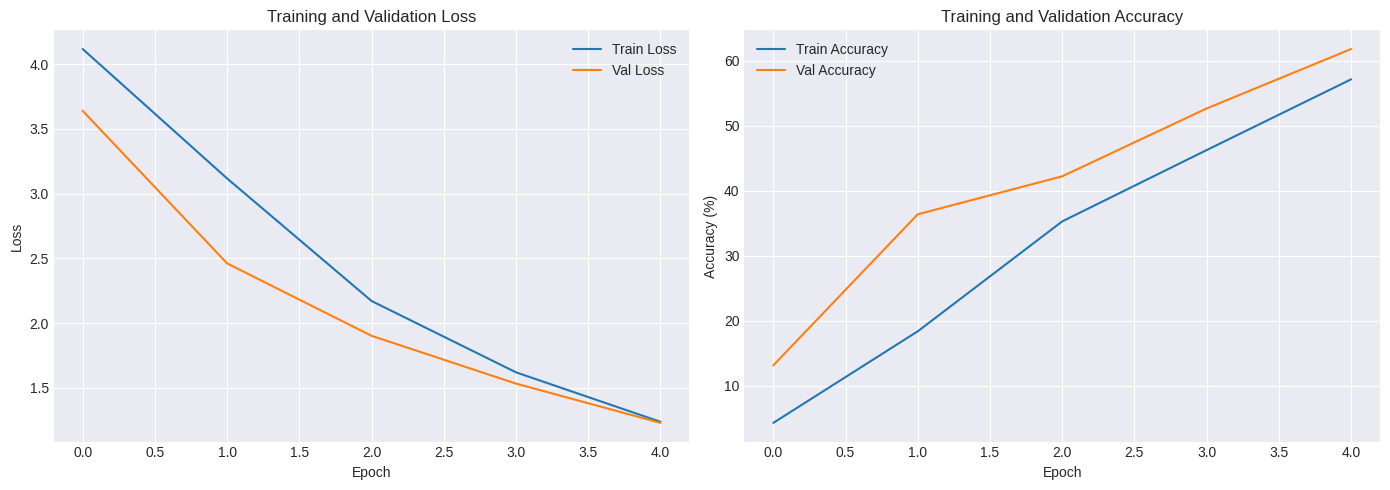

In [13]:
# Train the model
history = trainer.train(num_epochs=NUM_EPOCHS, save_dir='./checkpoints')
# Plot training history
trainer.plot_training_history()

In [14]:
import os
import torch

# Configuration
DATA_ROOT = './fgvc-aircraft-2013b'
VARIANT_LEVEL = 'family'  # Change to 'variant' or 'manufacturer' as needed
BATCH_SIZE = 32
NUM_EPOCHS = 5  # Start with 5 for testing, use 50+ for production
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the trained model
checkpoint_path = f'./checkpoints/best_model_{VARIANT_LEVEL}.pth'

if os.path.exists(checkpoint_path):
    engine = AircraftInferenceEngine(
        checkpoint_path=checkpoint_path,
        device=DEVICE
    )
    assistant = OperationalAssistant(engine)
    print("\nModel loaded successfully!")
else:
    print("Model checkpoint not found. Please train the model first.")

Inference engine initialized
Level: family | Classes: 70 | Device: cuda

Model loaded successfully!


In [17]:
import os

test_image_path = './fgvc-aircraft-2013b/data/images/1264191.jpg'

if os.path.exists(test_image_path) and 'assistant' in globals():
    planning_result = assistant.identify_for_stand_planning(test_image_path)

    print("STAND PLANNING ANALYSIS")
    print(f"\n Aircraft: {planning_result['aircraft_identified']}")
    print(f"Confidence: {planning_result['confidence']}")

    assumptions = planning_result['stand_planning_assumptions']
    print(f"\nCertainty: {assumptions['classification_certainty'].upper()}")
    print(f"\nRecommendation:")
    print(f"   {assumptions['recommendation']}")

    print(f"\nAlternative Possibilities:")
    for alt in assumptions['alternative_possibilities']:
        print(f"   • {alt}")


STAND PLANNING ANALYSIS

 Aircraft: MD-90
Confidence: 70.5%

Certainty: MEDIUM

Recommendation:
   Medium confidence - consider flexible stand allocation

Alternative Possibilities:
   • MD-80
   • Boeing 757


In [19]:
import os

test_image_path = './fgvc-aircraft-2013b/data/images/1264191.jpg'

# Detailed training analysis
if os.path.exists(test_image_path) and 'assistant' in globals():
    training_result = assistant.training_mode_analysis(test_image_path)

    print("TRAINING MODE ANALYSIS")
    print(f"\nIdentified Aircraft: {training_result['identified_aircraft']}")
    print(f"Confidence: {training_result['confidence_score'] * 100:.2f}%")

    print("\nLearning Points:")
    for point in training_result['learning_points']:
        print(f"   • {point}")

    print("\nVisual ID Features:")
    for feature in training_result['visual_identification_features']:
        print(f"   • {feature}")

    print("\nConfusion Risks:")
    for risk in training_result['confusion_risks']:
        print(f"   • {risk}")

    print("\nTop 10 Possibilities:")
    for pred in training_result['top_10_possibilities']:
        print(f"{pred['rank']:2d}. {pred['aircraft_type']:30s} {pred['confidence_percent']:>8s}")


TRAINING MODE ANALYSIS

Identified Aircraft: MD-90
Confidence: 70.53%

Learning Points:
   • Good classification with some visual ambiguity
   • Most similar: MD-80 (11.38%)

Visual ID Features:
   • Wing configuration
   • Engine placement
   • Fuselage shape
   • Specific to MD-90

Confusion Risks:
   • No significant confusion risks identified

Top 10 Possibilities:
 1. MD-90                            70.53%
 2. MD-80                            11.38%
 3. Boeing 757                        8.89%
 4. Boeing 717                        3.14%
 5. Fokker 100                        1.75%
 6. DC-9                              1.13%
 7. A340                              0.50%
 8. A330                              0.41%
 9. MD-11                             0.36%
10. Tu-154                            0.26%


In [20]:
# Process multiple images
if 'engine' in globals():
    test_images_dir = Path('./fgvc-aircraft-2013b/data/images')
    image_paths = [str(p) for p in list(test_images_dir.glob('*.jpg'))[:10]]

    print(f"Processing {len(image_paths)} images...\n")

    batch_results = engine.batch_predict(image_paths, top_k=3)

    # Display results
    for result in batch_results:
        img_name = Path(result['image_path']).name
        if 'error' not in result:
            print(f"{img_name:20s} → {result['primary_prediction']:30s} ({result['confidence']*100:.1f}%)")
        else:
            print(f"{img_name:20s} → ERROR: {result['error']}")

Processing 10 images...

2046831.jpg          → A380                           (52.2%)
0136180.jpg          → ATR-72                         (59.3%)
0950117.jpg          → MD-11                          (37.7%)
2156226.jpg          → Spitfire                       (99.8%)
1264191.jpg          → MD-90                          (70.5%)
0950562.jpg          → DC-6                           (92.3%)
1545983.jpg          → An-12                          (80.1%)
1137743.jpg          → CRJ-700                        (85.6%)
0709332.jpg          → King Air                       (50.5%)
0985695.jpg          → Embraer Legacy 600             (63.1%)


Inference engine initialized
Level: family | Classes: 70 | Device: cuda
Model loaded successfully!



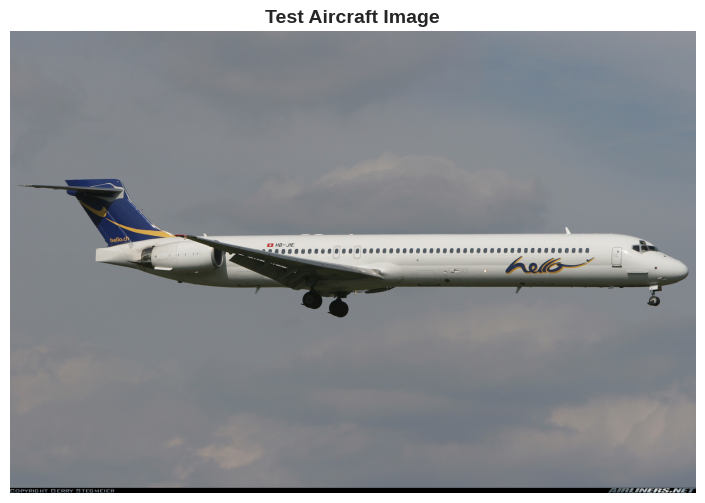


Primary Prediction: MD-90
Confidence: 70.53%
Inference Time: 45.09 ms



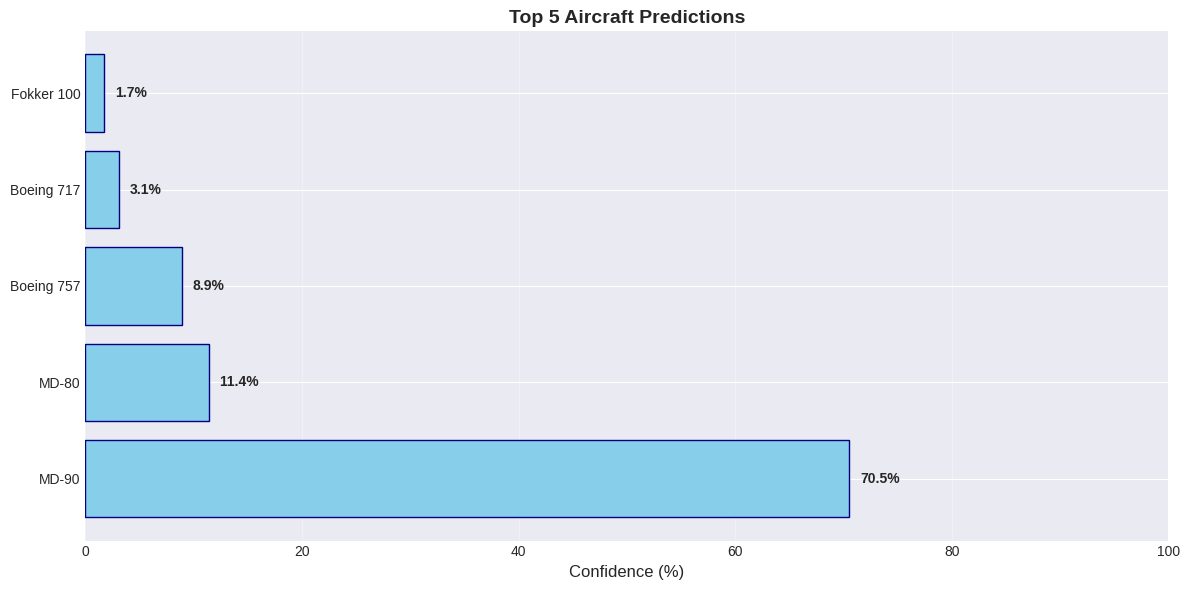


Stand Planning Recommendation:
Medium confidence - consider flexible stand allocation


In [25]:
# 1) Make sure the model is loaded
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError("Checkpoint not found. Train the model first.")

engine = AircraftInferenceEngine(checkpoint_path=checkpoint_path, device=DEVICE)
assistant = OperationalAssistant(engine)
print("Model loaded successfully!\n")


# 2) Pick a test image
test_image_path = "./fgvc-aircraft-2013b/data/images/1264191.jpg"
if not os.path.exists(test_image_path):
    raise FileNotFoundError("Test image not found. Please set a valid path.")


# 3) Display image
if os.path.exists(test_image_path):
    image = Image.open(test_image_path)
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title('Test Aircraft Image', fontsize=14, fontweight='bold')
    plt.show()
else:
    print("Test image not found. Please specify a valid image path.\n")


# 4) Predict top-5
result = engine.predict(test_image_path, top_k=5)
print("\nPrimary Prediction:", result["primary_prediction"])
print("Confidence:", f"{result['confidence']*100:.2f}%")
print("Inference Time:", f"{result['inference_time_ms']} ms\n")


# 5) Simple bar chart of top-5
if os.path.exists(test_image_path) and 'engine' in globals():
    result = engine.predict(test_image_path, top_k=5)

# Visualize predictions
if 'result' in globals():
    top_5 = result['top_predictions'][:5]
    aircraft_types = [p['aircraft_type'] for p in top_5]
    confidences = [p['confidence'] * 100 for p in top_5]

    plt.figure(figsize=(12, 6))
    bars = plt.barh(aircraft_types, confidences, color='skyblue', edgecolor='navy')
    plt.xlabel('Confidence (%)', fontsize=12)
    plt.title('Top 5 Aircraft Predictions', fontsize=14, fontweight='bold')
    plt.xlim(0, 100)

    # Add value labels
    for bar, conf in zip(bars, confidences):
        plt.text(conf + 1, bar.get_y() + bar.get_height()/2,
                f'{conf:.1f}%', va='center', fontsize=10, fontweight='bold')

    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()


# 6) Ops-style output
planning_result = assistant.identify_for_stand_planning(test_image_path)
print("\nStand Planning Recommendation:")
print(planning_result["stand_planning_assumptions"]["recommendation"])


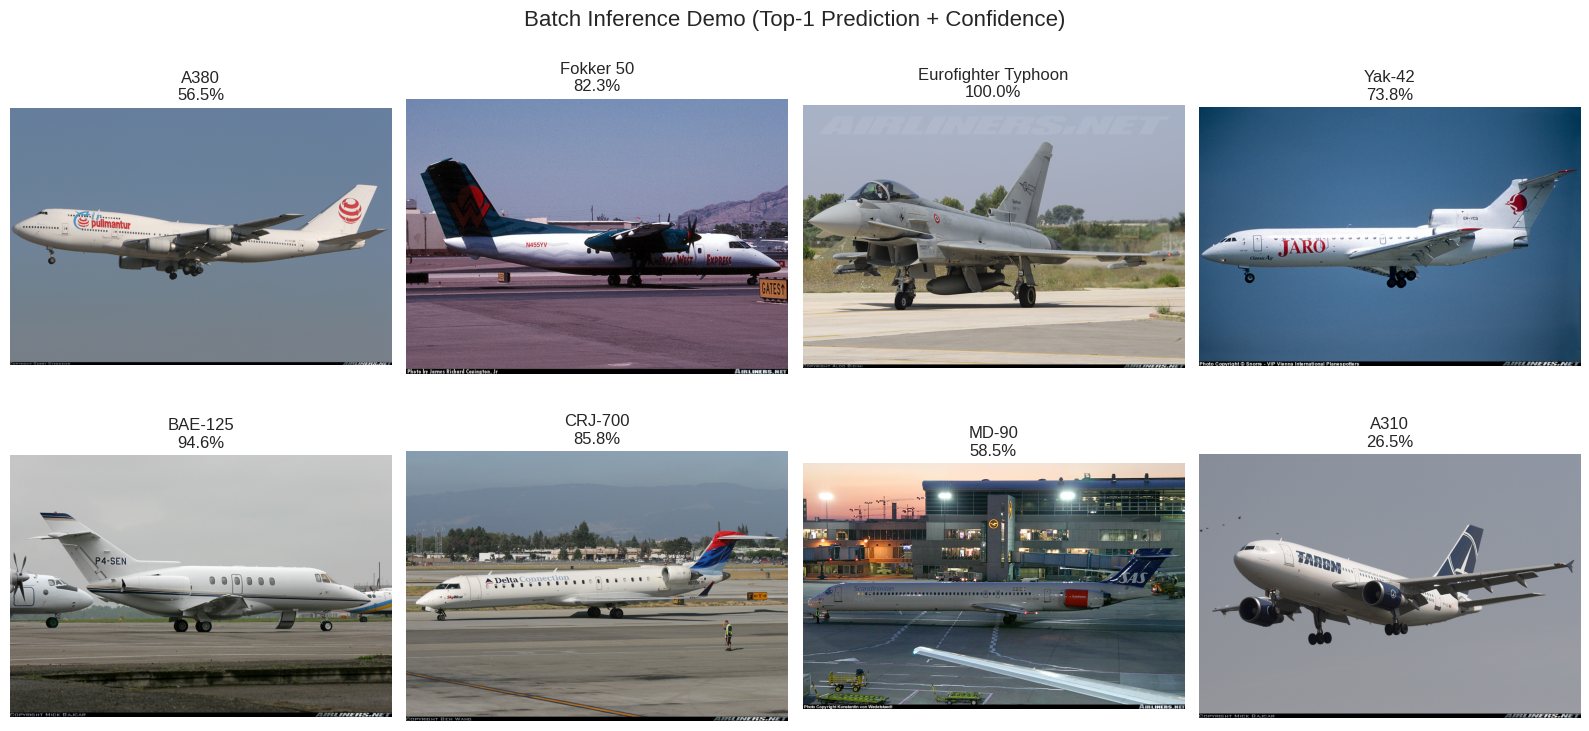

In [26]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# ---- Batch Demo: run predictions on N random images ----
images_dir = "./fgvc-aircraft-2013b/data/images"
all_imgs = [f for f in os.listdir(images_dir) if f.lower().endswith(".jpg")]

N = 8  # show 8 images in a grid
sample_imgs = random.sample(all_imgs, N)

plt.figure(figsize=(16, 8))
for i, img_name in enumerate(sample_imgs, 1):
    img_path = os.path.join(images_dir, img_name)

    # predict
    result = engine.predict(img_path, top_k=3)
    pred = result["primary_prediction"]
    conf = result["confidence"] * 100

    # show image
    img = Image.open(img_path).convert("RGB")
    plt.subplot(2, 4, i)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{pred}\n{conf:.1f}%")

plt.suptitle("Batch Inference Demo (Top-1 Prediction + Confidence)", fontsize=16)
plt.tight_layout()
plt.show()


In [27]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

def evaluate_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="weighted", zero_division=0
    )

    return acc, precision, recall, f1, all_labels, all_preds

# ---- Run evaluation ----
# Define model and test_loader from the trainer object
model = trainer.model
test_loader = trainer.val_loader

acc, prec, rec, f1, y_true, y_pred = evaluate_metrics(model, test_loader, DEVICE)

print(f"Test Accuracy:  {acc:.4f}")
print(f"Precision(w):   {prec:.4f}")
print(f"Recall(w):      {rec:.4f}")
print(f"F1-score(w):    {f1:.4f}")


Test Accuracy:  0.6184
Precision(w):   0.7133
Recall(w):      0.6184
F1-score(w):    0.6085


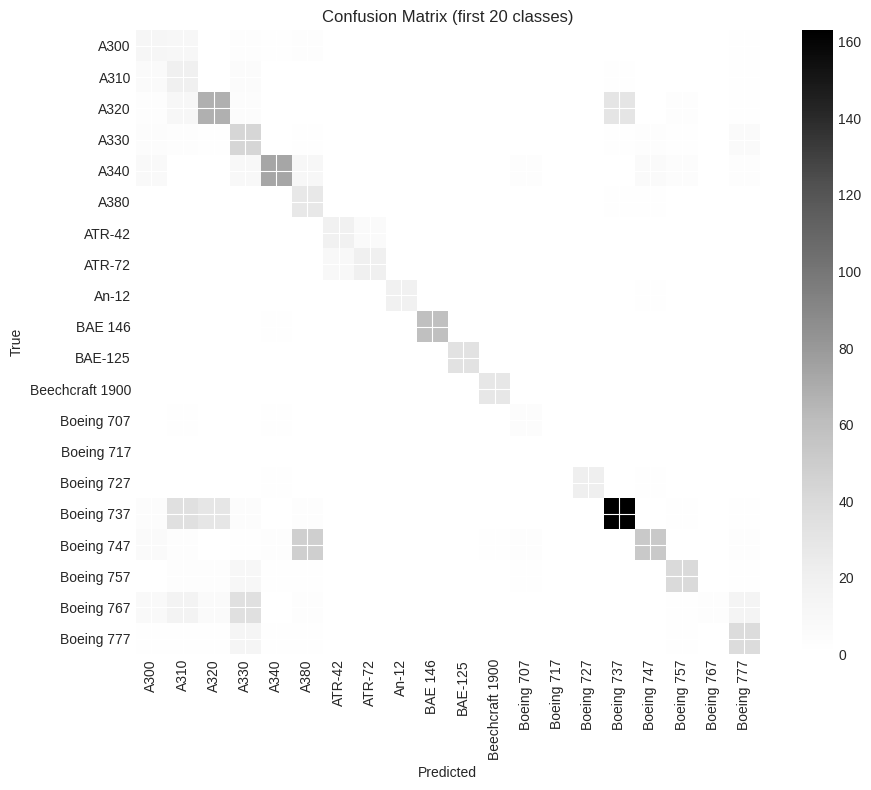

In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, class_names, max_classes=20):
    """
    If your dataset has many classes (FGVC can be a lot),
    showing ALL labels becomes unreadable.
    This plots only the first max_classes classes.
    """
    n = min(len(class_names), max_classes)
    cm_small = cm[:n, :n]
    names_small = class_names[:n]

    plt.figure(figsize=(10, 8))
    plt.imshow(cm_small)
    plt.title(f"Confusion Matrix (first {n} classes)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()
    plt.xticks(range(n), names_small, rotation=90)
    plt.yticks(range(n), names_small)
    plt.tight_layout()
    plt.show()

# Get class names from the trainer's dataset
class_names = trainer.train_dataset.unique_labels

# Re-evaluate metrics to get y_true and y_pred if they are not in scope
# (This is needed if the previous cell defining them was not executed just before this one)
if 'y_true' not in locals() or 'y_pred' not in locals():
    acc, prec, rec, f1, y_true, y_pred = evaluate_metrics(model, test_loader, DEVICE)

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_names, max_classes=20)


In [29]:
from collections import Counter

def top_confusions(cm, class_names, top_k=10):
    confusions = []
    for true_idx in range(cm.shape[0]):
        for pred_idx in range(cm.shape[1]):
            if true_idx != pred_idx and cm[true_idx, pred_idx] > 0:
                confusions.append((cm[true_idx, pred_idx], true_idx, pred_idx))

    confusions.sort(reverse=True, key=lambda x: x[0])

    print(f"Top {top_k} most common confusions:")
    for count, t, p in confusions[:top_k]:
        print(f"{class_names[t]}  →  {class_names[p]}   ({count} times)")

top_confusions(cm, class_names, top_k=10)


Top 10 most common confusions:
Boeing 747  →  A380   (48 times)
Dash 8  →  Fokker 50   (41 times)
Boeing 737  →  A310   (34 times)
Boeing 767  →  A330   (34 times)
Embraer ERJ 145  →  CRJ-700   (34 times)
DC-10  →  MD-11   (33 times)
A320  →  Boeing 737   (30 times)
Boeing 737  →  A320   (29 times)
MD-80  →  MD-90   (29 times)
CRJ-200  →  CRJ-700   (28 times)


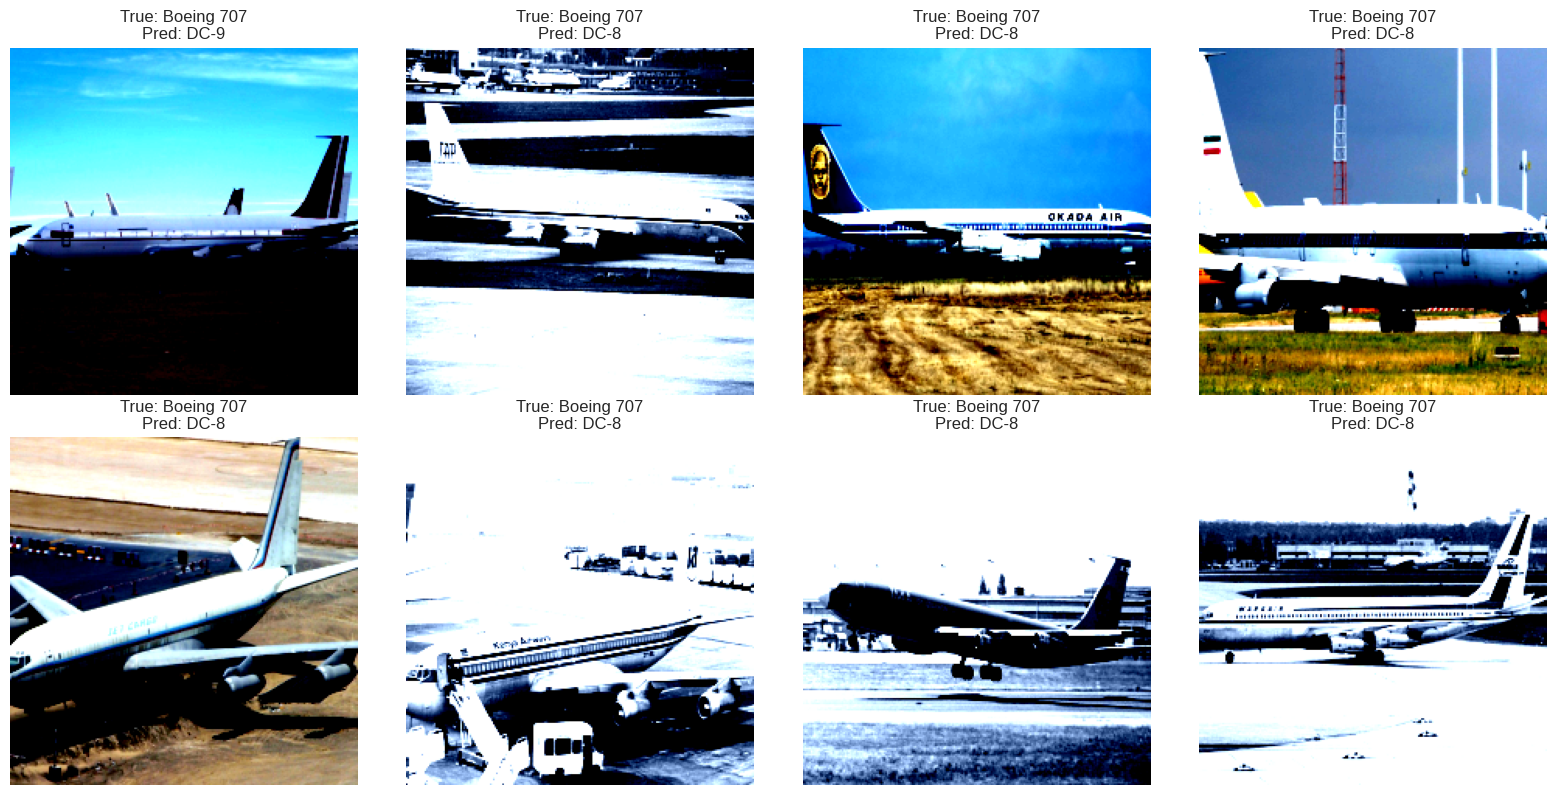

In [30]:
def show_misclassified_examples(model, dataloader, class_names, device, max_show=8):
    model.eval()
    shown = 0

    plt.figure(figsize=(16, 8))
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for i in range(images.size(0)):
                if preds[i] != labels[i]:
                    img = images[i].cpu().permute(1, 2, 0).numpy()
                    true_name = class_names[labels[i].item()]
                    pred_name = class_names[preds[i].item()]

                    plt.subplot(2, 4, shown + 1)
                    plt.imshow(np.clip(img, 0, 1))
                    plt.axis("off")
                    plt.title(f"True: {true_name}\nPred: {pred_name}")

                    shown += 1
                    if shown >= max_show:
                        plt.tight_layout()
                        plt.show()
                        return

    plt.tight_layout()
    plt.show()

show_misclassified_examples(model, test_loader, class_names, DEVICE, max_show=8)
